In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats
import os


In [3]:
# Add tensorboard stuff
# %load_ext tensorboard
# import datetime

# !rm -rf ./logs/


In [4]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [39]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             gray_frame = frame/np.maximum(np.max(frame),255) keep as int8 for memory savings
            gray_frame = frame
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [40]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [41]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [8]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)

n_test = (1,2,24,30,31,32,33,35,1,3)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
        
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
    
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
#     train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    train_dcamera_path = os.path.join(data_dir , 'depth_processed_'+subj[i]+'_test'+str(n_test[i])+'.avi')
    xtemp[i] = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize).astype('uint8')
    


In [9]:
tlen=0
for x in range(len(xtemp)):
    tlen+= xtemp[x].shape[0]
xrun_cum = 0
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]),dtype='uint8')
for i in range (len(xtemp)):
    xrun_n = len(xtemp[i])
    x_train[xrun_cum:xrun_cum+xrun_n,:,:,:] = xtemp[i][:xrun_n,:,:,:]
    xrun_cum += xrun_n

In [10]:
x_train.shape

(153421, 60, 80, 3)

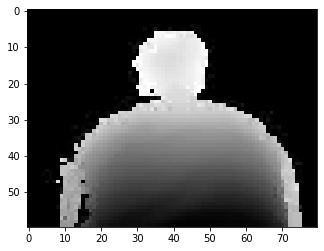

In [11]:
plt.imshow(x_train[153418])

In [12]:
print(x_train.shape)
del xtemp

(153421, 60, 80, 3)


# read fcss data

In [14]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
subjwgt = [61,61, 67, 67, 67, 67, 67, 67, 70, 70]
subjht = [180, 180, 174, 174, 174, 174, 174, 174, 170, 170]
xfcss_gt = {}
yrun = 0
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    fcss_data_dir = os.path.join(data_dir , 'fcss_processed_'+subj[i]+'_' + test_str + '_' + date[i] + '.txt')
    xfcss_gttemp = pd.read_csv(fcss_data_dir)/subjwgt[i]
    xfcss_gt[i]=xfcss_gttemp
#     xfcss_gt[i]['weight'] = subjwgt[i]# hacky but will work for now
#     xfcss_gt[i]['height'] = subjht[i]# hacky but will work for now
    if i==0:
        xfcss_train=xfcss_gttemp
    else:
        xfcss_train = pd.concat([xfcss_train,xfcss_gt[i]],axis=0)
del xfcss_gt

In [15]:
xfcss_train

,Fz bottom (kg),Fz left (kg),Fz right (kg),Fx left (kg),Fx right (kg),Fy (kg)
0,-0.828197,-0.189016,-0.198197,0.150164,0.196066,0.003934
1,-0.824918,-0.189836,-0.200328,0.150164,0.194918,0.003115
2,-0.822623,-0.191148,-0.202787,0.149836,0.194262,0.002623
3,-0.821148,-0.192787,-0.204590,0.150000,0.194918,0.002295
4,-0.821148,-0.194098,-0.206393,0.149836,0.196557,0.002295
...,...,...,...,...,...,...
23050,-0.710714,-0.272571,-0.248571,0.164429,0.182571,0.005857
23051,-0.711143,-0.269857,-0.248286,0.165571,0.178714,0.007000
23052,-0.710714,-0.266286,-0.248429,0.166143,0.174000,0.007714
23053,-0.710286,-0.263000,-0.248857,0.167143,0.169857,0.008000


# Read Output Data


In [16]:

n_test = (1,2,24,30,31,32,33,35,1,3)
date = ('12_2_2020','12_11_2020','11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020','12_2_2020','12_11_2020')
subj = ['cz','cz','leo','leo','leo','leo','leo','leo','yc','yc']
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = 'test' + str(n_test[i])
#     data_dir = os.path.join('/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    data_dir = os.path.join(r'C:\Users\Alex\Box\CS598 - Final Project\Preliminary Data V5','Test_Subject_'+subj[i],test_str)
    qtm_file_data_dir = os.path.join(data_dir , 'qtm_processed_'+subj[i]+'_test' + str(n_test[i]) + '_' + date[i] + '.txt')
    y_gt[i] = read_output_data(qtm_file_data_dir,theta_interest).values

    

# tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
# y_train = np.zeros((tlen,1))
# xrun = len(y_gt[0])
# y_train[:xrun] = y_gt[0][:xrun]
# xrun1 = xrun + len(y_gt[1])
# y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
# xrun2 = xrun1 + len(y_gt[2])
# y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
# xrun3 = xrun2 + len(y_gt[3])
# y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
# xrun4 = xrun3 + len(y_gt[4])
# y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
# xrun5 = xrun4 + len(y_gt[5])
# y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]
# del y_gt

In [17]:
tlen=0
for x in range(len(y_gt)):
    tlen+= y_gt[x].shape[0]
yrun_cum = 0
y_train = np.zeros((tlen,1))
for i in range (len(y_gt)):
    yrun_n = len(y_gt[i])
    y_train[yrun_cum:yrun_cum+yrun_n] = y_gt[i][:]
    yrun_cum += yrun_n

In [18]:
## Saturate output
# def saturate(theta, min_val, max_val):
#     for i in range(len(theta)):
#         if theta[i] < min_val:
#             theta[i] = min_val
#             continue
#         if theta[i] > max_val:
#             theta[i] = max_val
#             continue
#     return theta
            
# min_val = -50
# max_val = 50
    
# y_train = saturate(y_train, min_val, max_val)

In [19]:
print(x_train.shape)
print(xfcss_train.shape)
print(y_train.shape)

(153421, 60, 80, 3)
(153421, 6)
(153421, 1)


In [20]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [21]:
Trainset = x_train[rannums,:]
Trainset2 = xfcss_train.values[rannums,:]
Testset = x_train[test_set,:]
Testset2 = xfcss_train.values[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [22]:
sc_X2 = StandardScaler()
sc_y = StandardScaler()

In [23]:
Xtrainz = Trainset
Xtrainz2 = Trainset2
ytrainz = Trainy
X = Xtrainz
X2 = sc_X2.fit_transform(Xtrainz2)
y = sc_y.fit_transform(ytrainz)

In [24]:
#make validation data available to model.fit
Xvalid = Testset
Xvalid2 = sc_X2.transform(Testset2)
y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [25]:
# clear up some used variables
del Trainset
del Trainset2
del Testset
del Testset2


# Regress using Neural Network

In [26]:
x_train.shape

(153421, 60, 80, 3)

In [27]:
# Create Neural Netowrk

from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, concatenate, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten
from tensorflow.keras.models import Model
dropout_rate = 0.2

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_start2 = Input(shape=(xfcss_train.shape[1],))
model_cnn = model_start
model_perc = model_start2

model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_perc = Dense(32)(model_perc)
model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

# model_perc = Dense(32)(model_perc)
# model_perc = Activation('relu')(model_perc)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)

model_cnn = Flatten()(model_cnn)
# model_perc = Flatten()(model_perc)
# model_cnn = Activation('relu')(model_cnn)

# model_cnn = Dense(128)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_comb = concatenate([model_cnn,model_perc],axis=-1)

model_comb = Dense(128)(model_comb)
# model_comb = BatchNormalization()(model_comb)
model_comb = Activation('relu')(model_comb)
model_comb = Dropout(dropout_rate)(model_comb)

output = Dense(1)(model_comb)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=[model_start,model_start2],outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 

In [28]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 80, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 80, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 30, 40, 8)    0           activation[0][0]                 
_______________________________________________________________________________________

In [29]:
print(tf.__version__)

2.3.1


In [30]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
# # create data generator
# def get_generator_cyclic(features1, features2, labels, batch_size=256):
#     while True:
#         for n in range(int(len(features1)/batch_size)):
#             yield [features1[n*batch_size: (n+1)*batch_size]/255., features2[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size]]
#         permuted = np.random.permutation(len(features1))
#         features1 = features1[permuted]
#         features2 = features2[permuted]
#         labels = labels[permuted]


In [32]:
# x1, x2, y = next(training_generator)
# plt.imshow(x1[0])

In [33]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image_data_gen = ImageDataGenerator(rescale=1/255.,height_shift_range=0.2, fill_mode='nearest')

In [34]:
epochs = int(30000)
batch_size = 512
# training_generator = get_generator_cyclic(Xtrainz, Xtrainz2, ytrainz, batch_size=batch_size)
history = model.fit([X/255.,X2], y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = ([Xvalid/255.,Xvalid2], y_valid),verbose=2)
# history = model.fit_generator(get_generator_cyclic(Xtrainz, Xtrainz2, ytrainz, batch_size=batch_size))


# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Epoch 1/30000
240/240 - 14s - loss: 0.5299 - mse: 0.7406 - mae: 0.5299 - val_loss: 0.4737 - val_mse: 0.6444 - val_mae: 0.4737
Epoch 2/30000
240/240 - 11s - loss: 0.4552 - mse: 0.6001 - mae: 0.4552 - val_loss: 0.4376 - val_mse: 0.5767 - val_mae: 0.4376
Epoch 3/30000
240/240 - 11s - loss: 0.4225 - mse: 0.5448 - mae: 0.4225 - val_loss: 0.4024 - val_mse: 0.5256 - val_mae: 0.4024
Epoch 4/30000
240/240 - 11s - loss: 0.3995 - mse: 0.5085 - mae: 0.3995 - val_loss: 0.3831 - val_mse: 0.4934 - val_mae: 0.3831
Epoch 5/30000
240/240 - 11s - loss: 0.3799 - mse: 0.4790 - mae: 0.3799 - val_loss: 0.3655 - val_mse: 0.4684 - val_mae: 0.3655
Epoch 6/30000
240/240 - 11s - loss: 0.3634 - mse: 0.4553 - mae: 0.3634 - val_loss: 0.3491 - val_mse: 0.4455 - val_mae: 0.3491
Epoch 7/30000
240/240 - 11s - loss: 0.3518 - mse: 0.4379 - mae: 0.3518 - val_loss: 0.3402 - val_mse: 0.4323 - val_mae: 0.3402
Epoch 8/30000
240/240 - 11s - loss: 0.3408 - mse: 0.4228 - mae: 0.3408 - val_loss: 0.3270 - val_mse: 0.4148 - val_mae:

Epoch 66/30000
240/240 - 11s - loss: 0.2076 - mse: 0.2633 - mae: 0.2076 - val_loss: 0.2002 - val_mse: 0.2718 - val_mae: 0.2002
Epoch 67/30000
240/240 - 11s - loss: 0.2079 - mse: 0.2628 - mae: 0.2079 - val_loss: 0.2005 - val_mse: 0.2714 - val_mae: 0.2005
Epoch 68/30000
240/240 - 11s - loss: 0.2082 - mse: 0.2633 - mae: 0.2082 - val_loss: 0.2053 - val_mse: 0.2747 - val_mae: 0.2053
Epoch 69/30000
240/240 - 11s - loss: 0.2074 - mse: 0.2622 - mae: 0.2074 - val_loss: 0.1995 - val_mse: 0.2700 - val_mae: 0.1995
Epoch 70/30000
240/240 - 11s - loss: 0.2056 - mse: 0.2608 - mae: 0.2056 - val_loss: 0.1983 - val_mse: 0.2699 - val_mae: 0.1983
Epoch 71/30000
240/240 - 11s - loss: 0.2043 - mse: 0.2594 - mae: 0.2043 - val_loss: 0.1984 - val_mse: 0.2691 - val_mae: 0.1984
Epoch 72/30000
240/240 - 11s - loss: 0.2055 - mse: 0.2603 - mae: 0.2055 - val_loss: 0.2000 - val_mse: 0.2702 - val_mae: 0.2000
Epoch 73/30000
240/240 - 11s - loss: 0.2032 - mse: 0.2590 - mae: 0.2032 - val_loss: 0.1962 - val_mse: 0.2663 - 

Epoch 131/30000
240/240 - 11s - loss: 0.1813 - mse: 0.2371 - mae: 0.1813 - val_loss: 0.1804 - val_mse: 0.2520 - val_mae: 0.1804
Epoch 132/30000
240/240 - 11s - loss: 0.1824 - mse: 0.2375 - mae: 0.1824 - val_loss: 0.1819 - val_mse: 0.2529 - val_mae: 0.1819
Epoch 133/30000
240/240 - 11s - loss: 0.1805 - mse: 0.2365 - mae: 0.1805 - val_loss: 0.1791 - val_mse: 0.2514 - val_mae: 0.1791
Epoch 134/30000
240/240 - 11s - loss: 0.1806 - mse: 0.2362 - mae: 0.1806 - val_loss: 0.1797 - val_mse: 0.2509 - val_mae: 0.1797
Epoch 135/30000
240/240 - 11s - loss: 0.1821 - mse: 0.2376 - mae: 0.1821 - val_loss: 0.1775 - val_mse: 0.2487 - val_mae: 0.1775
Epoch 136/30000
240/240 - 11s - loss: 0.1800 - mse: 0.2354 - mae: 0.1800 - val_loss: 0.1815 - val_mse: 0.2513 - val_mae: 0.1815
Epoch 137/30000
240/240 - 11s - loss: 0.1801 - mse: 0.2358 - mae: 0.1801 - val_loss: 0.1762 - val_mse: 0.2483 - val_mae: 0.1762
Epoch 138/30000
240/240 - 11s - loss: 0.1804 - mse: 0.2358 - mae: 0.1804 - val_loss: 0.1776 - val_mse: 0

240/240 - 11s - loss: 0.1695 - mse: 0.2257 - mae: 0.1695 - val_loss: 0.1696 - val_mse: 0.2411 - val_mae: 0.1696
Epoch 196/30000
240/240 - 11s - loss: 0.1698 - mse: 0.2268 - mae: 0.1698 - val_loss: 0.1720 - val_mse: 0.2423 - val_mae: 0.1720
Epoch 197/30000
240/240 - 11s - loss: 0.1696 - mse: 0.2261 - mae: 0.1696 - val_loss: 0.1699 - val_mse: 0.2411 - val_mae: 0.1699
Epoch 198/30000
240/240 - 11s - loss: 0.1694 - mse: 0.2259 - mae: 0.1694 - val_loss: 0.1691 - val_mse: 0.2409 - val_mae: 0.1691
Epoch 199/30000
240/240 - 11s - loss: 0.1694 - mse: 0.2264 - mae: 0.1694 - val_loss: 0.1723 - val_mse: 0.2437 - val_mae: 0.1723
Epoch 200/30000
240/240 - 11s - loss: 0.1693 - mse: 0.2258 - mae: 0.1693 - val_loss: 0.1710 - val_mse: 0.2429 - val_mae: 0.1710
Epoch 201/30000
240/240 - 11s - loss: 0.1695 - mse: 0.2260 - mae: 0.1695 - val_loss: 0.1742 - val_mse: 0.2453 - val_mae: 0.1742
Epoch 202/30000
240/240 - 11s - loss: 0.1691 - mse: 0.2252 - mae: 0.1691 - val_loss: 0.1678 - val_mse: 0.2404 - val_mae:

Epoch 260/30000
240/240 - 11s - loss: 0.1623 - mse: 0.2195 - mae: 0.1623 - val_loss: 0.1658 - val_mse: 0.2347 - val_mae: 0.1658
Epoch 261/30000
240/240 - 11s - loss: 0.1621 - mse: 0.2191 - mae: 0.1621 - val_loss: 0.1657 - val_mse: 0.2377 - val_mae: 0.1657
Epoch 262/30000
240/240 - 11s - loss: 0.1619 - mse: 0.2189 - mae: 0.1619 - val_loss: 0.1675 - val_mse: 0.2372 - val_mae: 0.1675
Epoch 263/30000
240/240 - 11s - loss: 0.1615 - mse: 0.2183 - mae: 0.1615 - val_loss: 0.1622 - val_mse: 0.2352 - val_mae: 0.1622
Epoch 264/30000
240/240 - 11s - loss: 0.1621 - mse: 0.2187 - mae: 0.1621 - val_loss: 0.1661 - val_mse: 0.2376 - val_mae: 0.1661
Epoch 265/30000
240/240 - 11s - loss: 0.1611 - mse: 0.2181 - mae: 0.1611 - val_loss: 0.1649 - val_mse: 0.2367 - val_mae: 0.1649
Epoch 266/30000
240/240 - 11s - loss: 0.1621 - mse: 0.2191 - mae: 0.1621 - val_loss: 0.1638 - val_mse: 0.2362 - val_mae: 0.1638
Epoch 267/30000
240/240 - 11s - loss: 0.1618 - mse: 0.2179 - mae: 0.1618 - val_loss: 0.1619 - val_mse: 0

240/240 - 11s - loss: 0.1573 - mse: 0.2076 - mae: 0.1573 - val_loss: 0.1604 - val_mse: 0.2251 - val_mae: 0.1604
Epoch 325/30000
240/240 - 11s - loss: 0.1566 - mse: 0.2073 - mae: 0.1566 - val_loss: 0.1586 - val_mse: 0.2232 - val_mae: 0.1586
Epoch 326/30000
240/240 - 11s - loss: 0.1563 - mse: 0.2057 - mae: 0.1563 - val_loss: 0.1607 - val_mse: 0.2280 - val_mae: 0.1607
Epoch 327/30000
240/240 - 11s - loss: 0.1571 - mse: 0.2064 - mae: 0.1571 - val_loss: 0.1601 - val_mse: 0.2250 - val_mae: 0.1601
Epoch 328/30000
240/240 - 11s - loss: 0.1562 - mse: 0.2038 - mae: 0.1562 - val_loss: 0.1592 - val_mse: 0.2252 - val_mae: 0.1592
Epoch 329/30000
240/240 - 11s - loss: 0.1564 - mse: 0.2030 - mae: 0.1564 - val_loss: 0.1597 - val_mse: 0.2151 - val_mae: 0.1597
Epoch 330/30000
240/240 - 11s - loss: 0.1567 - mse: 0.2035 - mae: 0.1567 - val_loss: 0.1575 - val_mse: 0.2228 - val_mae: 0.1575
Epoch 331/30000
240/240 - 11s - loss: 0.1567 - mse: 0.2018 - mae: 0.1567 - val_loss: 0.1629 - val_mse: 0.2217 - val_mae:

Epoch 389/30000
240/240 - 11s - loss: 0.1498 - mse: 0.1734 - mae: 0.1498 - val_loss: 0.1591 - val_mse: 0.1888 - val_mae: 0.1591
Epoch 390/30000
240/240 - 11s - loss: 0.1511 - mse: 0.1734 - mae: 0.1511 - val_loss: 0.1572 - val_mse: 0.1874 - val_mae: 0.1572
Epoch 391/30000
240/240 - 11s - loss: 0.1507 - mse: 0.1707 - mae: 0.1507 - val_loss: 0.1556 - val_mse: 0.1886 - val_mae: 0.1556
Epoch 392/30000
240/240 - 11s - loss: 0.1505 - mse: 0.1722 - mae: 0.1505 - val_loss: 0.1530 - val_mse: 0.1861 - val_mae: 0.1530
Epoch 393/30000
240/240 - 11s - loss: 0.1497 - mse: 0.1710 - mae: 0.1497 - val_loss: 0.1547 - val_mse: 0.1926 - val_mae: 0.1547
Epoch 394/30000
240/240 - 11s - loss: 0.1503 - mse: 0.1689 - mae: 0.1503 - val_loss: 0.1546 - val_mse: 0.1874 - val_mae: 0.1546
Epoch 395/30000
240/240 - 11s - loss: 0.1498 - mse: 0.1717 - mae: 0.1498 - val_loss: 0.1553 - val_mse: 0.1873 - val_mae: 0.1553
Epoch 396/30000
240/240 - 11s - loss: 0.1498 - mse: 0.1683 - mae: 0.1498 - val_loss: 0.1525 - val_mse: 0

240/240 - 11s - loss: 0.1465 - mse: 0.1662 - mae: 0.1465 - val_loss: 0.1561 - val_mse: 0.1836 - val_mae: 0.1561
Epoch 454/30000
240/240 - 11s - loss: 0.1464 - mse: 0.1627 - mae: 0.1464 - val_loss: 0.1539 - val_mse: 0.1817 - val_mae: 0.1539
Epoch 455/30000
240/240 - 11s - loss: 0.1464 - mse: 0.1654 - mae: 0.1464 - val_loss: 0.1518 - val_mse: 0.1808 - val_mae: 0.1518
Epoch 456/30000
240/240 - 11s - loss: 0.1471 - mse: 0.1631 - mae: 0.1471 - val_loss: 0.1533 - val_mse: 0.1918 - val_mae: 0.1533
Epoch 457/30000
240/240 - 11s - loss: 0.1463 - mse: 0.1621 - mae: 0.1463 - val_loss: 0.1580 - val_mse: 0.1821 - val_mae: 0.1580
Epoch 458/30000
240/240 - 11s - loss: 0.1469 - mse: 0.1652 - mae: 0.1469 - val_loss: 0.1513 - val_mse: 0.1807 - val_mae: 0.1513
Epoch 459/30000
240/240 - 11s - loss: 0.1458 - mse: 0.1623 - mae: 0.1458 - val_loss: 0.1528 - val_mse: 0.1779 - val_mae: 0.1528
Epoch 460/30000
240/240 - 11s - loss: 0.1455 - mse: 0.1606 - mae: 0.1455 - val_loss: 0.1530 - val_mse: 0.1766 - val_mae:

Epoch 518/30000
240/240 - 11s - loss: 0.1442 - mse: 0.1631 - mae: 0.1442 - val_loss: 0.1533 - val_mse: 0.1749 - val_mae: 0.1533
Epoch 519/30000
240/240 - 11s - loss: 0.1446 - mse: 0.1620 - mae: 0.1446 - val_loss: 0.1576 - val_mse: 0.1773 - val_mae: 0.1576
Epoch 520/30000
240/240 - 11s - loss: 0.1439 - mse: 0.1617 - mae: 0.1439 - val_loss: 0.1514 - val_mse: 0.1774 - val_mae: 0.1514
Epoch 521/30000
240/240 - 11s - loss: 0.1437 - mse: 0.1631 - mae: 0.1437 - val_loss: 0.1513 - val_mse: 0.1789 - val_mae: 0.1513
Epoch 522/30000
240/240 - 11s - loss: 0.1437 - mse: 0.1596 - mae: 0.1437 - val_loss: 0.1529 - val_mse: 0.1836 - val_mae: 0.1529
Epoch 523/30000
240/240 - 11s - loss: 0.1442 - mse: 0.1599 - mae: 0.1442 - val_loss: 0.1525 - val_mse: 0.1742 - val_mae: 0.1525
Epoch 524/30000
240/240 - 11s - loss: 0.1434 - mse: 0.1591 - mae: 0.1434 - val_loss: 0.1505 - val_mse: 0.1806 - val_mae: 0.1505
Epoch 525/30000
240/240 - 11s - loss: 0.1433 - mse: 0.1576 - mae: 0.1433 - val_loss: 0.1541 - val_mse: 0

240/240 - 11s - loss: 0.1412 - mse: 0.1441 - mae: 0.1412 - val_loss: 0.1486 - val_mse: 0.1558 - val_mae: 0.1486
Epoch 583/30000
240/240 - 11s - loss: 0.1405 - mse: 0.1476 - mae: 0.1405 - val_loss: 0.1483 - val_mse: 0.1569 - val_mae: 0.1483
Epoch 584/30000
240/240 - 11s - loss: 0.1410 - mse: 0.1452 - mae: 0.1410 - val_loss: 0.1525 - val_mse: 0.1586 - val_mae: 0.1525
Epoch 585/30000
240/240 - 11s - loss: 0.1408 - mse: 0.1379 - mae: 0.1408 - val_loss: 0.1489 - val_mse: 0.1555 - val_mae: 0.1489
Epoch 586/30000
240/240 - 11s - loss: 0.1410 - mse: 0.1439 - mae: 0.1410 - val_loss: 0.1484 - val_mse: 0.1565 - val_mae: 0.1484
Epoch 587/30000
240/240 - 11s - loss: 0.1408 - mse: 0.1363 - mae: 0.1408 - val_loss: 0.1494 - val_mse: 0.1648 - val_mae: 0.1494
Epoch 588/30000
240/240 - 11s - loss: 0.1410 - mse: 0.1420 - mae: 0.1410 - val_loss: 0.1496 - val_mse: 0.1620 - val_mae: 0.1496
Epoch 589/30000
240/240 - 11s - loss: 0.1406 - mse: 0.1408 - mae: 0.1406 - val_loss: 0.1494 - val_mse: 0.1622 - val_mae:

Epoch 647/30000
240/240 - 11s - loss: 0.1388 - mse: 0.1299 - mae: 0.1388 - val_loss: 0.1471 - val_mse: 0.1515 - val_mae: 0.1471
Epoch 648/30000
240/240 - 11s - loss: 0.1376 - mse: 0.1251 - mae: 0.1376 - val_loss: 0.1491 - val_mse: 0.1566 - val_mae: 0.1491
Epoch 649/30000
240/240 - 11s - loss: 0.1393 - mse: 0.1353 - mae: 0.1393 - val_loss: 0.1470 - val_mse: 0.1534 - val_mae: 0.1470
Epoch 650/30000
240/240 - 11s - loss: 0.1376 - mse: 0.1298 - mae: 0.1376 - val_loss: 0.1511 - val_mse: 0.1530 - val_mae: 0.1511
Epoch 651/30000
240/240 - 11s - loss: 0.1381 - mse: 0.1326 - mae: 0.1381 - val_loss: 0.1506 - val_mse: 0.1527 - val_mae: 0.1506
Epoch 652/30000
240/240 - 11s - loss: 0.1382 - mse: 0.1265 - mae: 0.1382 - val_loss: 0.1485 - val_mse: 0.1531 - val_mae: 0.1485
Epoch 653/30000
240/240 - 11s - loss: 0.1388 - mse: 0.1386 - mae: 0.1388 - val_loss: 0.1495 - val_mse: 0.1520 - val_mae: 0.1495
Epoch 654/30000
240/240 - 11s - loss: 0.1385 - mse: 0.1343 - mae: 0.1385 - val_loss: 0.1511 - val_mse: 0

240/240 - 11s - loss: 0.1366 - mse: 0.1214 - mae: 0.1366 - val_loss: 0.1488 - val_mse: 0.1490 - val_mae: 0.1488
Epoch 712/30000
240/240 - 11s - loss: 0.1364 - mse: 0.1212 - mae: 0.1364 - val_loss: 0.1477 - val_mse: 0.1451 - val_mae: 0.1477
Epoch 713/30000
240/240 - 11s - loss: 0.1372 - mse: 0.1286 - mae: 0.1372 - val_loss: 0.1521 - val_mse: 0.1535 - val_mae: 0.1521
Epoch 714/30000
240/240 - 11s - loss: 0.1359 - mse: 0.1217 - mae: 0.1359 - val_loss: 0.1477 - val_mse: 0.1464 - val_mae: 0.1477
Epoch 715/30000
240/240 - 11s - loss: 0.1374 - mse: 0.1275 - mae: 0.1374 - val_loss: 0.1528 - val_mse: 0.1491 - val_mae: 0.1528
Epoch 716/30000
240/240 - 11s - loss: 0.1359 - mse: 0.1254 - mae: 0.1359 - val_loss: 0.1493 - val_mse: 0.1481 - val_mae: 0.1493
Epoch 717/30000
240/240 - 11s - loss: 0.1365 - mse: 0.1269 - mae: 0.1365 - val_loss: 0.1461 - val_mse: 0.1446 - val_mae: 0.1461
Epoch 718/30000
240/240 - 11s - loss: 0.1358 - mse: 0.1252 - mae: 0.1358 - val_loss: 0.1500 - val_mse: 0.1471 - val_mae:

Epoch 776/30000
240/240 - 11s - loss: 0.1352 - mse: 0.1231 - mae: 0.1352 - val_loss: 0.1482 - val_mse: 0.1511 - val_mae: 0.1482
Epoch 777/30000
240/240 - 11s - loss: 0.1351 - mse: 0.1272 - mae: 0.1351 - val_loss: 0.1478 - val_mse: 0.1426 - val_mae: 0.1478
Epoch 778/30000
240/240 - 11s - loss: 0.1348 - mse: 0.1256 - mae: 0.1348 - val_loss: 0.1468 - val_mse: 0.1415 - val_mae: 0.1468
Epoch 779/30000
240/240 - 11s - loss: 0.1348 - mse: 0.1228 - mae: 0.1348 - val_loss: 0.1488 - val_mse: 0.1408 - val_mae: 0.1488
Epoch 780/30000
240/240 - 11s - loss: 0.1343 - mse: 0.1182 - mae: 0.1343 - val_loss: 0.1472 - val_mse: 0.1434 - val_mae: 0.1472
Epoch 781/30000
240/240 - 11s - loss: 0.1343 - mse: 0.1201 - mae: 0.1343 - val_loss: 0.1457 - val_mse: 0.1414 - val_mae: 0.1457
Epoch 782/30000
240/240 - 11s - loss: 0.1353 - mse: 0.1262 - mae: 0.1353 - val_loss: 0.1471 - val_mse: 0.1510 - val_mae: 0.1471
Epoch 783/30000
240/240 - 11s - loss: 0.1358 - mse: 0.1271 - mae: 0.1358 - val_loss: 0.1458 - val_mse: 0

240/240 - 11s - loss: 0.1333 - mse: 0.1143 - mae: 0.1333 - val_loss: 0.1460 - val_mse: 0.1478 - val_mae: 0.1460
Epoch 841/30000
240/240 - 11s - loss: 0.1342 - mse: 0.1251 - mae: 0.1342 - val_loss: 0.1473 - val_mse: 0.1438 - val_mae: 0.1473
Epoch 842/30000
240/240 - 11s - loss: 0.1329 - mse: 0.1188 - mae: 0.1329 - val_loss: 0.1471 - val_mse: 0.1457 - val_mae: 0.1471
Epoch 843/30000
240/240 - 11s - loss: 0.1334 - mse: 0.1169 - mae: 0.1334 - val_loss: 0.1468 - val_mse: 0.1414 - val_mae: 0.1468
Epoch 844/30000
240/240 - 11s - loss: 0.1343 - mse: 0.1261 - mae: 0.1343 - val_loss: 0.1464 - val_mse: 0.1431 - val_mae: 0.1464
Epoch 845/30000
240/240 - 11s - loss: 0.1323 - mse: 0.1163 - mae: 0.1323 - val_loss: 0.1484 - val_mse: 0.1416 - val_mae: 0.1484
Epoch 846/30000
240/240 - 11s - loss: 0.1340 - mse: 0.1257 - mae: 0.1340 - val_loss: 0.1462 - val_mse: 0.1413 - val_mae: 0.1462
Epoch 847/30000
240/240 - 11s - loss: 0.1338 - mse: 0.1218 - mae: 0.1338 - val_loss: 0.1443 - val_mse: 0.1431 - val_mae:

Epoch 905/30000
240/240 - 11s - loss: 0.1321 - mse: 0.1181 - mae: 0.1321 - val_loss: 0.1485 - val_mse: 0.1425 - val_mae: 0.1485
Epoch 906/30000
240/240 - 11s - loss: 0.1318 - mse: 0.1166 - mae: 0.1318 - val_loss: 0.1471 - val_mse: 0.1454 - val_mae: 0.1471
Epoch 907/30000
240/240 - 11s - loss: 0.1324 - mse: 0.1222 - mae: 0.1324 - val_loss: 0.1465 - val_mse: 0.1430 - val_mae: 0.1465
Epoch 908/30000
240/240 - 11s - loss: 0.1326 - mse: 0.1212 - mae: 0.1326 - val_loss: 0.1457 - val_mse: 0.1423 - val_mae: 0.1457
Epoch 909/30000
240/240 - 11s - loss: 0.1328 - mse: 0.1157 - mae: 0.1328 - val_loss: 0.1507 - val_mse: 0.1473 - val_mae: 0.1507
Epoch 910/30000
240/240 - 11s - loss: 0.1323 - mse: 0.1188 - mae: 0.1323 - val_loss: 0.1450 - val_mse: 0.1439 - val_mae: 0.1450
Epoch 911/30000
240/240 - 11s - loss: 0.1317 - mse: 0.1154 - mae: 0.1317 - val_loss: 0.1444 - val_mse: 0.1442 - val_mae: 0.1444
Epoch 912/30000
240/240 - 11s - loss: 0.1324 - mse: 0.1172 - mae: 0.1324 - val_loss: 0.1452 - val_mse: 0

240/240 - 11s - loss: 0.1317 - mse: 0.1201 - mae: 0.1317 - val_loss: 0.1446 - val_mse: 0.1410 - val_mae: 0.1446
Epoch 970/30000
240/240 - 11s - loss: 0.1311 - mse: 0.1165 - mae: 0.1311 - val_loss: 0.1462 - val_mse: 0.1398 - val_mae: 0.1462
Epoch 971/30000
240/240 - 11s - loss: 0.1306 - mse: 0.1116 - mae: 0.1306 - val_loss: 0.1466 - val_mse: 0.1408 - val_mae: 0.1466
Epoch 972/30000
240/240 - 11s - loss: 0.1316 - mse: 0.1176 - mae: 0.1316 - val_loss: 0.1462 - val_mse: 0.1411 - val_mae: 0.1462
Epoch 973/30000
240/240 - 11s - loss: 0.1313 - mse: 0.1186 - mae: 0.1313 - val_loss: 0.1453 - val_mse: 0.1421 - val_mae: 0.1453
Epoch 974/30000
240/240 - 11s - loss: 0.1310 - mse: 0.1171 - mae: 0.1310 - val_loss: 0.1463 - val_mse: 0.1455 - val_mae: 0.1463
Epoch 975/30000
240/240 - 11s - loss: 0.1315 - mse: 0.1147 - mae: 0.1315 - val_loss: 0.1452 - val_mse: 0.1430 - val_mae: 0.1452
Epoch 976/30000
240/240 - 11s - loss: 0.1312 - mse: 0.1190 - mae: 0.1312 - val_loss: 0.1464 - val_mse: 0.1413 - val_mae:

Epoch 1033/30000
240/240 - 11s - loss: 0.1303 - mse: 0.1234 - mae: 0.1303 - val_loss: 0.1487 - val_mse: 0.1430 - val_mae: 0.1487
Epoch 1034/30000
240/240 - 11s - loss: 0.1298 - mse: 0.1143 - mae: 0.1298 - val_loss: 0.1458 - val_mse: 0.1451 - val_mae: 0.1458
Epoch 1035/30000
240/240 - 11s - loss: 0.1302 - mse: 0.1151 - mae: 0.1302 - val_loss: 0.1449 - val_mse: 0.1459 - val_mae: 0.1449
Epoch 1036/30000
240/240 - 11s - loss: 0.1305 - mse: 0.1148 - mae: 0.1305 - val_loss: 0.1470 - val_mse: 0.1436 - val_mae: 0.1470
Epoch 1037/30000
240/240 - 11s - loss: 0.1306 - mse: 0.1199 - mae: 0.1306 - val_loss: 0.1475 - val_mse: 0.1427 - val_mae: 0.1475
Epoch 1038/30000
240/240 - 11s - loss: 0.1302 - mse: 0.1143 - mae: 0.1302 - val_loss: 0.1479 - val_mse: 0.1390 - val_mae: 0.1479
Epoch 1039/30000
240/240 - 11s - loss: 0.1309 - mse: 0.1214 - mae: 0.1309 - val_loss: 0.1468 - val_mse: 0.1428 - val_mae: 0.1468
Epoch 1040/30000
240/240 - 11s - loss: 0.1309 - mse: 0.1159 - mae: 0.1309 - val_loss: 0.1453 - va

Epoch 1097/30000
240/240 - 11s - loss: 0.1298 - mse: 0.1171 - mae: 0.1298 - val_loss: 0.1434 - val_mse: 0.1395 - val_mae: 0.1434
Epoch 1098/30000
240/240 - 11s - loss: 0.1293 - mse: 0.1111 - mae: 0.1293 - val_loss: 0.1480 - val_mse: 0.1401 - val_mae: 0.1480
Epoch 1099/30000
240/240 - 11s - loss: 0.1294 - mse: 0.1113 - mae: 0.1294 - val_loss: 0.1443 - val_mse: 0.1420 - val_mae: 0.1443
Epoch 1100/30000
240/240 - 11s - loss: 0.1303 - mse: 0.1173 - mae: 0.1303 - val_loss: 0.1442 - val_mse: 0.1360 - val_mae: 0.1442
Epoch 1101/30000
240/240 - 11s - loss: 0.1302 - mse: 0.1160 - mae: 0.1302 - val_loss: 0.1433 - val_mse: 0.1382 - val_mae: 0.1433
Epoch 1102/30000
240/240 - 11s - loss: 0.1288 - mse: 0.1131 - mae: 0.1288 - val_loss: 0.1445 - val_mse: 0.1424 - val_mae: 0.1445
Epoch 1103/30000
240/240 - 11s - loss: 0.1297 - mse: 0.1136 - mae: 0.1297 - val_loss: 0.1451 - val_mse: 0.1483 - val_mae: 0.1451
Epoch 1104/30000
240/240 - 11s - loss: 0.1298 - mse: 0.1122 - mae: 0.1298 - val_loss: 0.1450 - va

Epoch 1161/30000
240/240 - 11s - loss: 0.1286 - mse: 0.1097 - mae: 0.1286 - val_loss: 0.1481 - val_mse: 0.1366 - val_mae: 0.1481
Epoch 1162/30000
240/240 - 11s - loss: 0.1290 - mse: 0.1135 - mae: 0.1290 - val_loss: 0.1483 - val_mse: 0.1456 - val_mae: 0.1483
Epoch 1163/30000
240/240 - 11s - loss: 0.1297 - mse: 0.1172 - mae: 0.1297 - val_loss: 0.1508 - val_mse: 0.1447 - val_mae: 0.1508
Epoch 1164/30000
240/240 - 11s - loss: 0.1292 - mse: 0.1104 - mae: 0.1292 - val_loss: 0.1499 - val_mse: 0.1443 - val_mae: 0.1499
Epoch 1165/30000
240/240 - 11s - loss: 0.1296 - mse: 0.1165 - mae: 0.1296 - val_loss: 0.1454 - val_mse: 0.1426 - val_mae: 0.1454
Epoch 1166/30000
240/240 - 11s - loss: 0.1291 - mse: 0.1133 - mae: 0.1291 - val_loss: 0.1460 - val_mse: 0.1379 - val_mae: 0.1460
Epoch 1167/30000
240/240 - 11s - loss: 0.1301 - mse: 0.1172 - mae: 0.1301 - val_loss: 0.1437 - val_mse: 0.1355 - val_mae: 0.1437
Epoch 1168/30000
240/240 - 11s - loss: 0.1288 - mse: 0.1115 - mae: 0.1288 - val_loss: 0.1468 - va

In [ ]:
#%tensorboard --logdir logs/fit

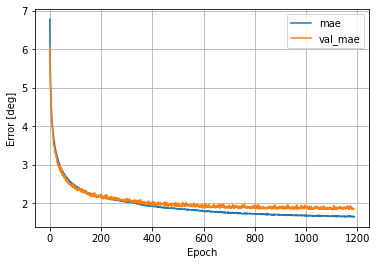

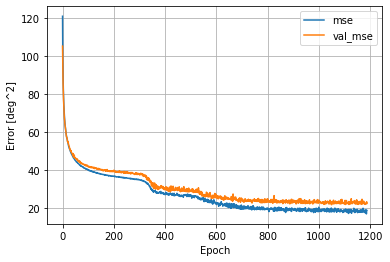

In [35]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

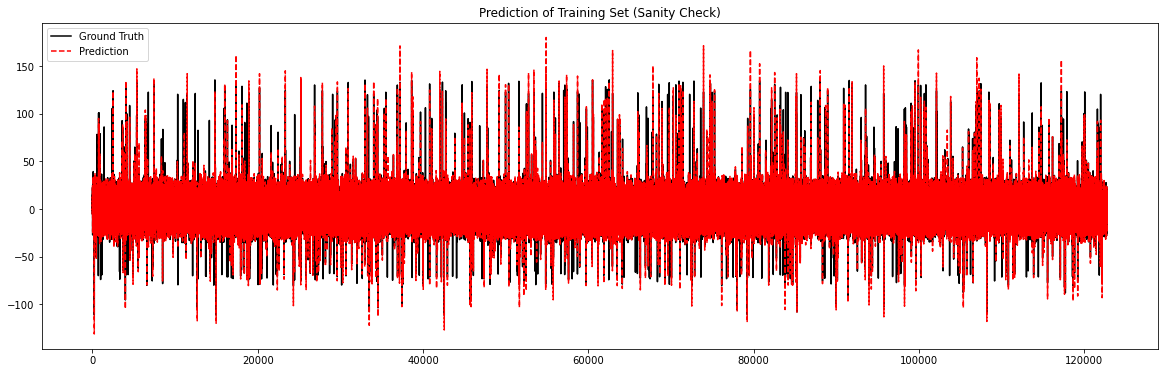

Average error is -0.21 degrees
Root Mean Squared Error is 1.43 degrees
Mean Absolute Error is 1.43 degrees


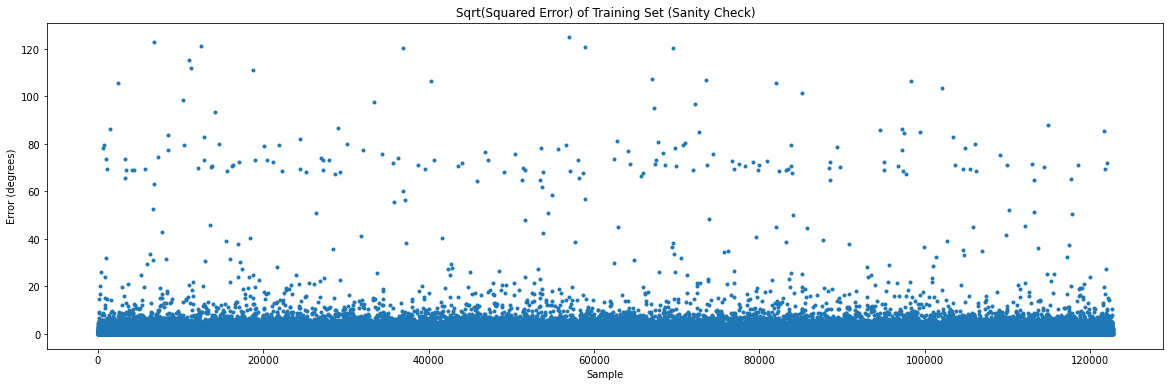

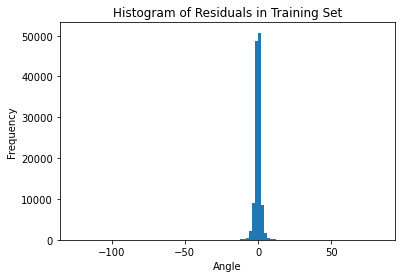

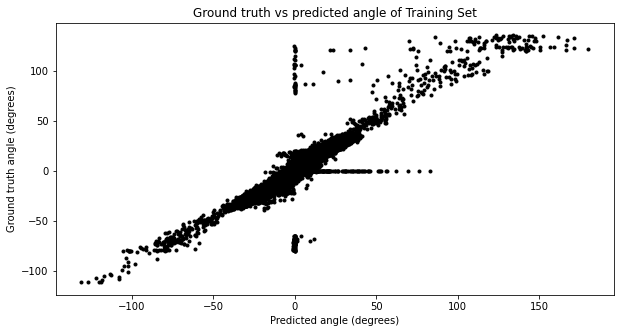

In [46]:

# sanity check with 80% data
Xtrainz = Trainset/255.
Xtrainz2 = sc_X2.transform(Trainset2)
y_pred = model.predict([Xtrainz,Xtrainz2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

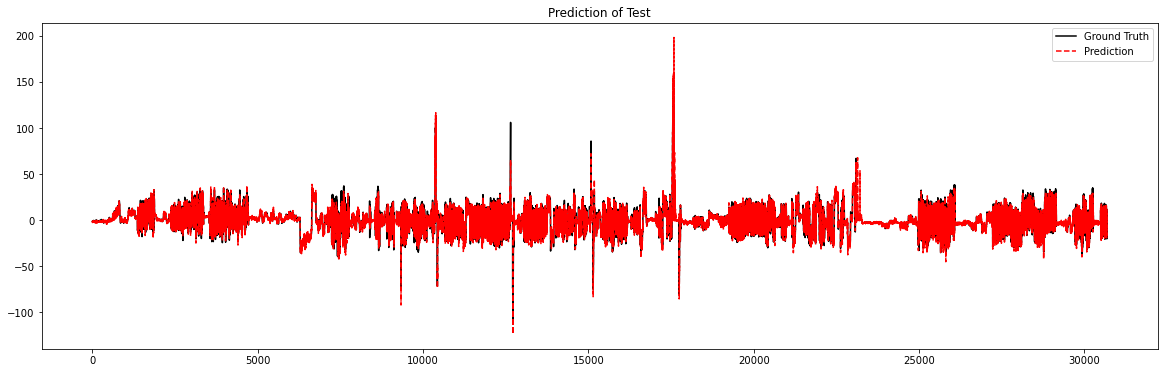

Average error is -0.20 degrees
Root Mean Squared Error is 2.14 degrees
Mean Absolute Error is 2.14 degrees


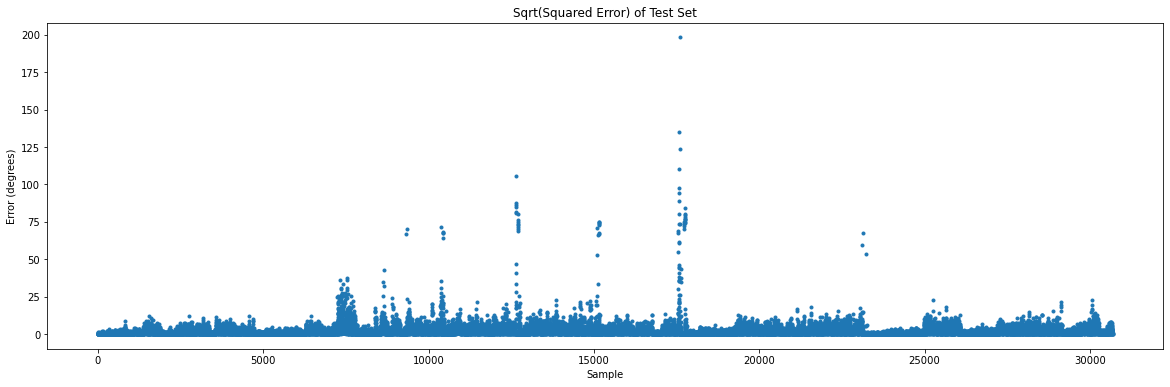

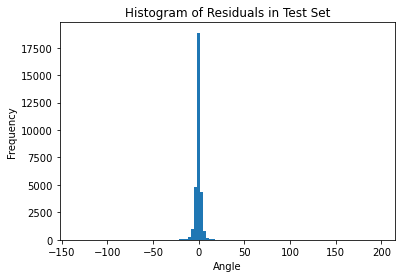

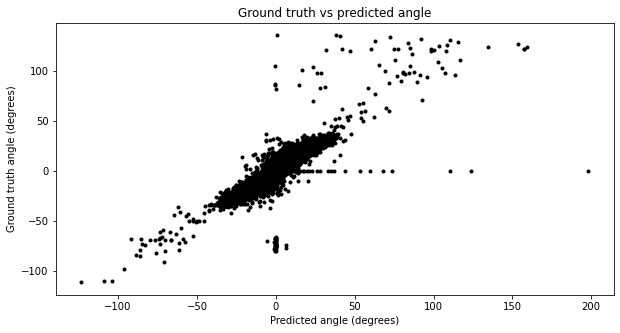

In [47]:
# Redo test set
Xtest = Testset/255.
Xtest2 = sc_X2.transform(Testset2)
y_pred = model.predict([Xtest,Xtest2])
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [38]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v22_pb.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,sc_X2,modelhistory], file)
        
#     !mkdir -p saved_model
#     model.save('saved_model/cnn3v22')

In [42]:
model.save('saved_model/cnn3v22.h5')

In [48]:
del tf